# Vehicle Tire Condition Detection using MobileNet_v2


The goal of this project is to develop a machine learning model capable of detecting the condition of vehicle tires. The model will classify tire images into two categories: "perfect" and "defective". This binary classification problem aims to enhance vehicle safety by providing a reliable and efficient method for identifying tire defects, which are critical for preventing accidents and ensuring road safety.

According to the National Highway Traffic Safety Administration (NHTSA), tire-related crashes contribute to approximately 11,000 traffic accidents annually in the United States. Proper tire maintenance and timely detection of tire defects can significantly reduce these numbers and improve overall vehicle safety.

## Project Overview

The primary objective of this project is to enhance vehicle safety by providing a reliable method for identifying tire defects. Tire-related crashes are a significant concern, and timely detection of defects can prevent accidents and ensure road safety.

## Key Features

- **Binary Classification**: Classifies tire images into "perfect" and "defective".
- **Transfer Learning**: Utilizes MobileNet_v2 for efficient and accurate predictions.
- **Real-Time Detection**: Provides quick and reliable classification results.

## Dataset

The dataset consists of images of vehicle tires categorized into "perfect" and "defective". The data is split into training, validation, and test sets.
Dataset was obtained from roboflow website credit for dataset is due to contributor as roboflow

## Model Architecture

The model is built using MobileNet_v2 as the base model, with additional custom layers for the binary classification task.

## Importing Libraries

In this section, we import the necessary libraries for data manipulation, model building, training, and evaluation. We also ensure that TensorFlow can manage GPU memory growth to prevent memory issues.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-07-03 03:41:58.994788: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 03:42:00.082634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


def set_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

set_memory_growth()

## Loading Data

This section covers loading the dataset using the image_dataset_from_directory. We define the paths for the training, validation, and test datasets Batch Size and Image size .

In [2]:

def load_data(train_dir, val_dir, test_dir,IMG_SIZE, BATCH_SIZE):
    train_dataset = tf.keras.utils.image_dataset_from_directory(train_directory,
                                                         shuffle=True,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMG_SIZE )
    validation_dataset = tf.keras.utils.image_dataset_from_directory(valid_directory,
                                                         shuffle=True,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMG_SIZE )
    test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory, 
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMG_SIZE )
    return train_dataset,validation_dataset,test_dataset

BATCH_SIZE = 32
IMG_SIZE = (224,224)
train_directory = '/home/arsalan/DATA/github_files/keras_cv/TyreQualityPrediction/dataset/train'
valid_directory = '/home/arsalan/DATA/github_files/keras_cv/TyreQualityPrediction/dataset/valid'
test_directory = '/home/arsalan/DATA/github_files/keras_cv/TyreQualityPrediction/dataset/test'

train_dataset, validation_dataset, test_dataset = load_data(train_directory, valid_directory, test_directory, IMG_SIZE, BATCH_SIZE)

Found 4411 files belonging to 2 classes.


2024-07-03 03:42:01.524167: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 03:42:01.582167: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 03:42:01.588684: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 163 files belonging to 2 classes.
Found 182 files belonging to 2 classes.


Lets make sure our class names are same in all datasets and carry same order .



In [3]:
train_dataset_class_names = train_dataset.class_names
test_dataset_class_names = test_dataset.class_names
validation_dataset_class_names = validation_dataset.class_names

print(f"Class names in train dataset:{train_dataset_class_names}")
print(f"in test dataset:{test_dataset_class_names}")
print(f"and vlidation data set : {validation_dataset_class_names}")

Class names in train dataset:['defective', 'perfect']
in test dataset:['defective', 'perfect']
and vlidation data set : ['defective', 'perfect']


Lets take a look at some of examples to get some idea .

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


2024-07-03 03:42:03.281787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


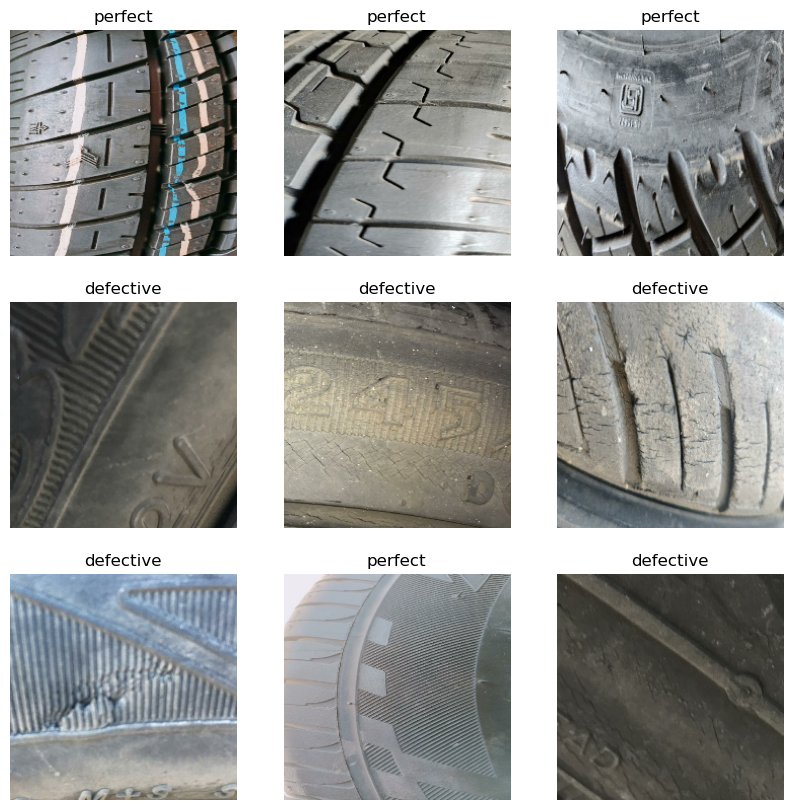

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)  
    print("Label batch shape:", labels.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_dataset_class_names[labels[i]])
        plt.axis("off")

## Optimizing Data Pipeline

To optimize the data input pipeline, we use TensorFlow's `AUTOTUNE` feature. This allows the runtime to automatically determine the best parameters for data loading and preprocessing. By caching the dataset and prefetching the data with `AUTOTUNE`, we ensure that the data pipeline can keep up with the training loop, thereby improving performance. 
As we have less data so augementation would be good idea to get some more examples to train on. 
We Will use `Sequential` keras model composed of 2 layers to augment our data:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`
These two seems much logical at this point as people can take pictures of their tyres with different angles .


In [5]:
data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal'),
      tf.keras.layers.RandomRotation(0.2),
    ])

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y)).cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Take a look at how an image from the training set has been augmented with simple transformations:


Next, we will start working on building our model . First thing which we need to do for the MobileNet application in TensorFlow, is normalize input. Since we're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

## Model Definition

In this section, we define the model architecture using MobileNet_v2 as the base model. We add custom layers on top for our specific binary classification task. MobileNet_v2 is a lightweight deep learning model pre-trained on the ImageNet dataset, making it ideal for transfer learning.

In [7]:
# Define the input shape including the number of color channels (3 for RGB)
IMG_SHAPE = IMG_SIZE + (3,)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [8]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
def model(inputshape, preprocess_input,base_model):
    # Define the input layer with the specified input shape
    inputs = tf.keras.Input(shape=inputshape)
    
    # Preprocess the inputs using the MobileNetV2 preprocessing function
    x = preprocess_input(inputs)
    
    # Pass the preprocessed inputs through the base model (MobileNetV2)
    x = base_model(x, training=False)
    
    # Apply global average pooling to reduce the spatial dimensions
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Apply a dropout layer with a 20% dropout rate for regularization
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Add a dense output layer with a single neuron and sigmoid activation function for binary classification
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Create the model by specifying the inputs and outputs
    model = tf.keras.Model(inputs, outputs)
    
    # Return the constructed model
    return model



# Create the model with the specified input shape and set the base model layers as non-trainable
model = model(IMG_SHAPE,preprocess_input,base_model)


In [10]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training the Model

This section involves compiling the model, defining callbacks, and training the model on the training dataset while validating on the validation dataset. We use the Adam optimizer and Binary cross-entropy loss function.

In [22]:
callbacks = [
    # ModelCheckpoint callback saves the model after every epoch.
    # The filename includes the accuracy, validation accuracy, loss, and validation loss.
    tf.keras.callbacks.ModelCheckpoint(
        'model_accuracy:{accuracy:0.2f}_Val_acc:{val_accuracy:0.2f}_loss:{loss:0.2f}_Val_loss:{val_loss:0.2f}.keras', 
        save_best_only=True,  # Save only the best model based on the monitored metric.
        monitor='val_accuracy'  # Monitor the validation accuracy to determine the best model.
    ),
    # EarlyStopping callback stops training when the monitored metric has stopped improving.
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',  # Monitor the validation accuracy.
        patience= 8,  # Number of epochs with no improvement after which training will be stopped.
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric.
    )
]


In [12]:
def compile_model(model, learning_rate):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

                  
def fit_model(model, train_dataset, validation_dataset, initial_epochs , callbacks):                  
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks= callbacks)
    return history


In [13]:
learning_rate = 1e-4
initial_epochs = 20
compile_model(model, learning_rate)
history = fit_model(model, train_dataset, validation_dataset, initial_epochs ,callbacks)

Epoch 1/20


I0000 00:00:1719945730.592982   86662 service.cc:145] XLA service 0x706e94044e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719945730.593047   86662 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-07-03 03:42:10.727140: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-03 03:42:11.622424: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  2/138 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.4297 - loss: 0.9552  

I0000 00:00:1719945740.413508   86662 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 ━━━━━━━━━━━━━━━━━━━━ 55s 292ms/step - accuracy: 0.5643 - loss: 0.7639 - val_accuracy: 0.6687 - val_loss: 0.6178
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.7181 - loss: 0.5447 - val_accuracy: 0.7607 - val_loss: 0.4690
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.7891 - loss: 0.4381 - val_accuracy: 0.8160 - val_loss: 0.3885
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8377 - loss: 0.3803 - val_accuracy: 0.8650 - val_loss: 0.3391
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8481 - loss: 0.3543 - val_accuracy: 0.8773 - val_loss: 0.3057
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8687 - loss: 0.3222 - val_accuracy: 0.9018 - val_loss: 0.2814
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8736 - loss: 0.3075 - val_accuracy: 0.9080 - val_loss: 0.2659
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8826 - loss: 0.2924 - val_accuracy: 0.9

Lets Visualize what we have so far ....

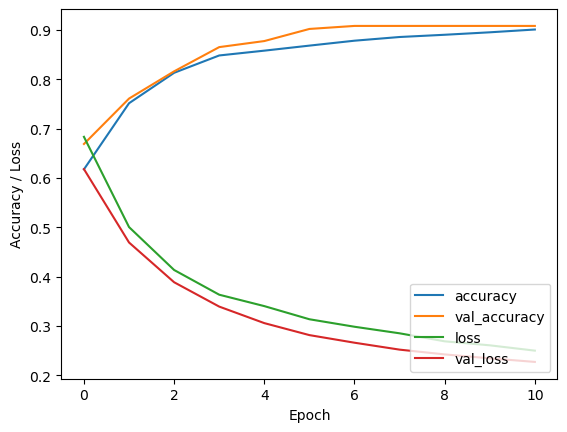

In [14]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Loss')
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)

Its looks like we are on right track as all these graphs show very nice convergence response . 
Lets now try fine tuning and see if we can get some more validaton accuraccy .

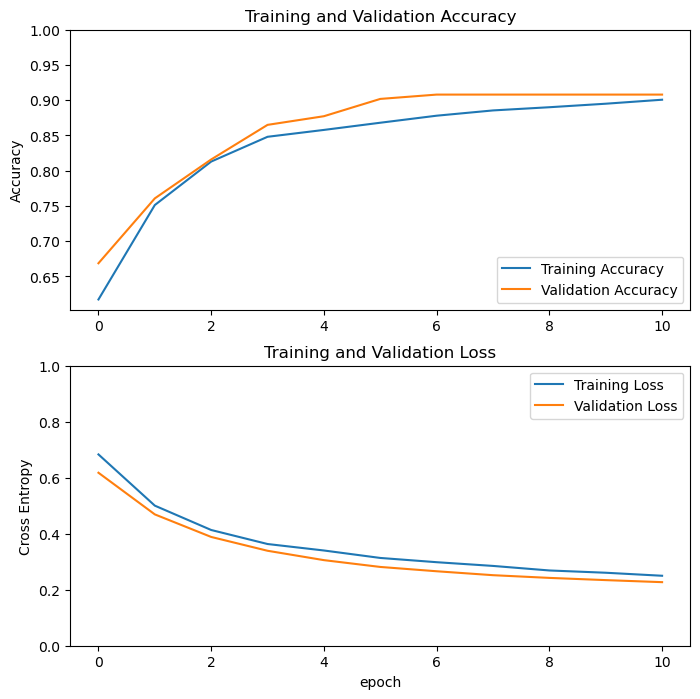

In [15]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    return acc ,val_acc,loss,val_loss

acc ,val_acc,loss,val_loss = plot_history(history)

## Fine Tune 

First step is to set base mode trainable to True so we can train those weights as well.
Initally we will not train all layers but will choose 50 layers to train.

In [16]:
base_model.trainable = True

In [17]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


As there are 154 layers in our base model .
Lets freez all layers weights from 0 to 100-1 .

In [18]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile Model again with more smaller learning rate

In [19]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 2,564 (10.02 KB)

In [20]:
learning_rate = 1e-5
initial_epochs = 20
compile_model(model, learning_rate)

In [23]:
# Define the number of epochs for fine-tuning
fine_tune_epochs = 20  # Number of epochs for fine-tuning after initial training

# Calculate the total number of epochs for the entire training process
total_epochs = initial_epochs + fine_tune_epochs

# Define a function to fit the model with fine-tuning
def fit_model_finetune(train_dataset, validation_dataset, initial_epochs, total_epochs, callbacks):
    # Fit the model using the training dataset
    # Start training from the last completed epoch in the initial training phase
    fine_tune_history = model.fit(
        train_dataset,
        epochs=total_epochs,  # Train until the total number of epochs is reached
        initial_epoch=len(history.epoch),  # Continue training from the epoch where initial training stopped
        validation_data=validation_dataset,  # Use the validation dataset for validation
        callbacks=callbacks  # Use the specified callbacks for saving the model and early stopping
    )
    return fine_tune_history  # Return the training history of the fine-tuning phase

# Perform fine-tuning on the model using the training and validation datasets
fine_tune_history = fit_model_finetune(train_dataset, validation_dataset, initial_epochs, total_epochs, callbacks)


Epoch 12/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.9164 - loss: 0.2247 - val_accuracy: 0.9080 - val_loss: 0.2175
Epoch 13/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.9526 - loss: 0.1522 - val_accuracy: 0.9018 - val_loss: 0.2184
Epoch 14/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.9694 - loss: 0.1113 - val_accuracy: 0.9018 - val_loss: 0.2176
Epoch 15/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9856 - loss: 0.0797 - val_accuracy: 0.9141 - val_loss: 0.2207
Epoch 16/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9923 - loss: 0.0590 - val_accuracy: 0.9202 - val_loss: 0.2193
Epoch 17/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.9952 - loss: 0.0438 - val_accuracy: 0.9202 - val_loss: 0.2109
Epoch 18/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9978 - loss: 0.0327 - val_accuracy: 0.9264 - val_loss: 0.2118
Epoch 19/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.9986 - loss: 0

In [24]:

acc += fine_tune_history.history['accuracy']
val_acc += fine_tune_history.history['val_accuracy']

loss += fine_tune_history.history['loss']
val_loss += fine_tune_history.history['val_loss']

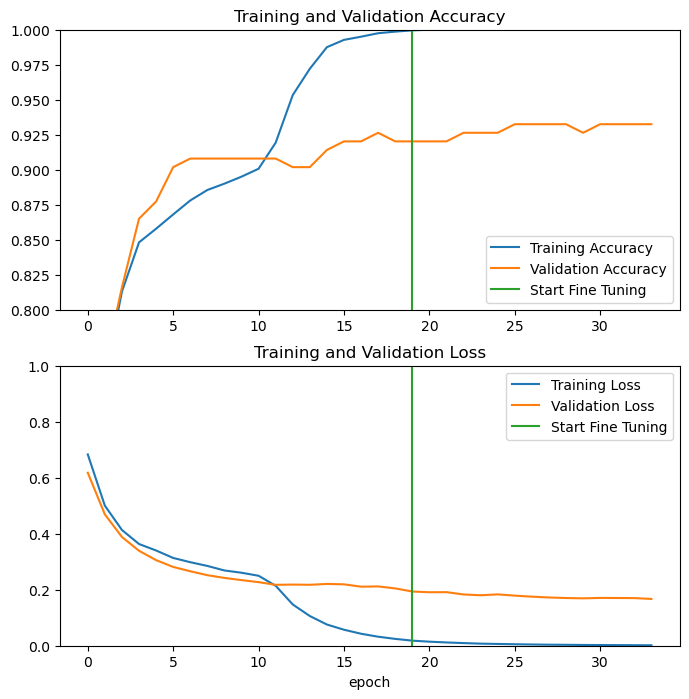

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

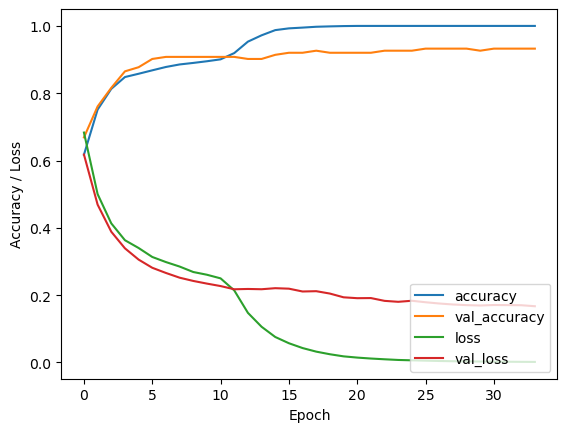

In [26]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Loss')
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)

WE can clearly see that our validation accuracy did't improve after 19th apochs .
Also our model has over fit training data and approached to 100% accuracy and 0% loss .
lets see below how will that model perform on test data set .

In [27]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9545 - loss: 0.1599  
Test accuracy : 0.9450549483299255


Not bad , 95% accuracy at test data set is still better .
so lets continue with this model and calculate confusion matrix and generate classification report .
But first lets have a look at some of test examples our model has evaluated .

In [28]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)



Predictions:
 [0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0]
Labels:
 [0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0]


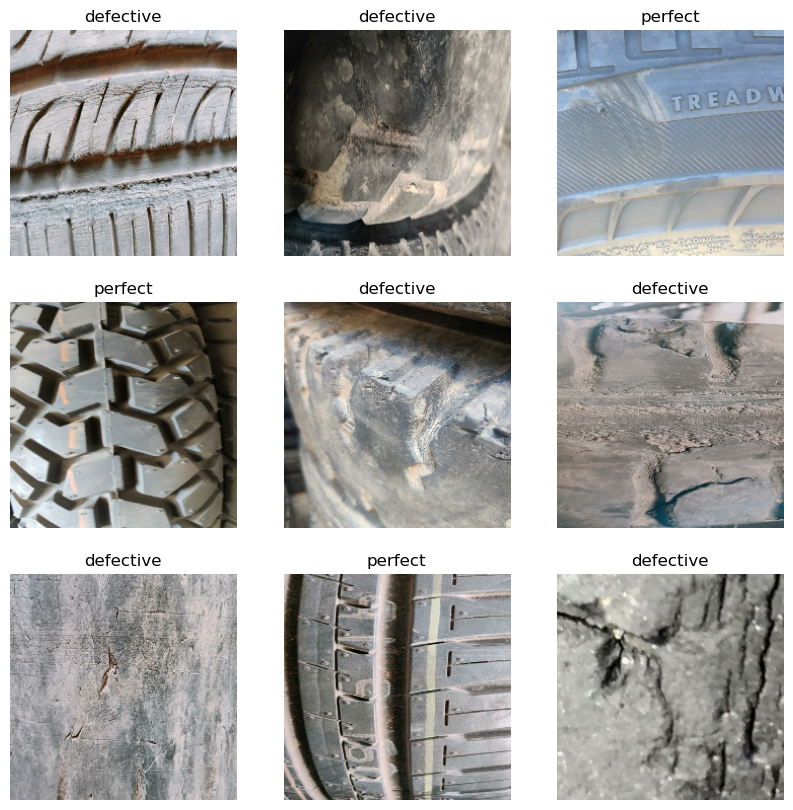

In [29]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(test_dataset_class_names[predictions[i]])
  plt.axis("off")

### Lets get confusion matrix and classification report 

In [30]:
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns

In [31]:
# Initialize lists to accumulate predictions and labels
all_predictions = []
all_labels = []

# Iterate through the dataset
for image_batch, label_batch in test_dataset:
    predictions = model.predict_on_batch(image_batch).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)
    
    # Append current batch predictions and labels to the lists
    all_predictions.extend(predictions.numpy())
    all_labels.extend(label_batch.numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Print or visualize predictions and labels
print('All Predictions:\n', all_predictions)
print('All Labels:\n', all_labels)

All Predictions:
 [0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1
 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0
 1 1 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0
 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0]
All Labels:
 [0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1
 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0
 0 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0
 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0]


2024-07-03 04:04:41.778194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
len(all_predictions),len(all_labels)

(182, 182)

In [33]:
cm = confusion_matrix(all_labels, all_predictions)
cm

array([[100,   5],
       [  5,  72]])

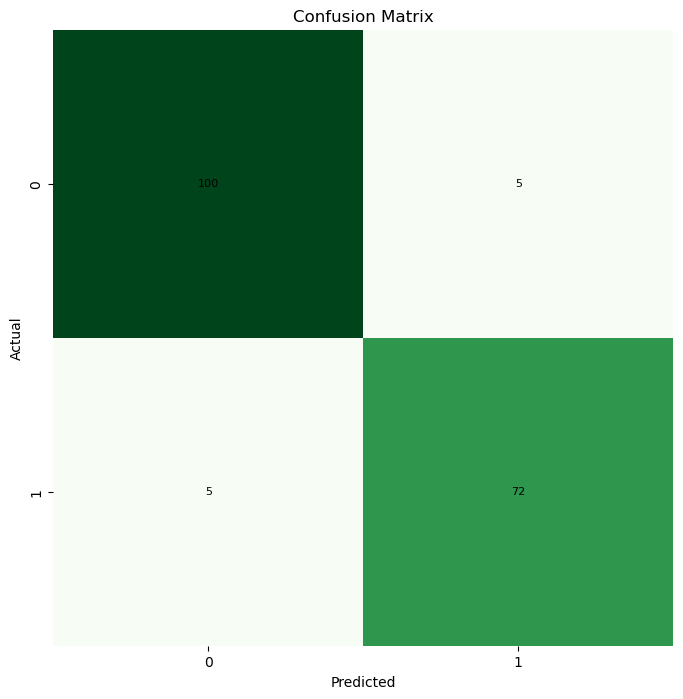

In [34]:
# Plot confusion matrix with annotations for all values
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Add annotations for correct classifications
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j + 0.5, i + 0.5, f'{cm[i, j]}', ha='center', va='center', color='black', fontsize=8)

plt.show()

In [35]:
#Calculate and print accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, accuracy in enumerate(class_accuracies):
    print(f'Accuracy for class {i}: {accuracy:.2f}')

Accuracy for class 0: 0.95
Accuracy for class 1: 0.94


In [36]:
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       105
           1       0.94      0.94      0.94        77

    accuracy                           0.95       182
   macro avg       0.94      0.94      0.94       182
weighted avg       0.95      0.95      0.95       182



### Classification Report Description

As classification report provides a detailed breakdown of the performance metrics for a binary classification model. Here is the detailed description of each part of the report:

#### Overall Metrics:
- **Accuracy**: The overall accuracy of the model is 0.95, meaning that 95% of the predictions made by the model are correct.

#### Class-Specific Metrics:
The report provides metrics for each class (0 and 1), including precision, recall, and F1-score.

1. **Class 0 (Perfect Tire)**:
    - **Precision**: 0.95
        - This means that 95% of the instances predicted as class 0 (perfect tire) are actually class 0.
    - **Recall**: 0.95
        - This means that 95% of the actual class 0 instances are correctly identified by the model.
    - **F1-Score**: 0.95
        - This is the harmonic mean of precision and recall, providing a balance between the two metrics.
    - **Support**: 105
        - This is the number of true instances of class 0 in the dataset.

2. **Class 1 (Defective Tire)**:
    - **Precision**: 0.94
        - This means that 94% of the instances predicted as class 1 (defective tire) are actually class 1.
    - **Recall**: 0.94
        - This means that 94% of the actual class 1 instances are correctly identified by the model.
    - **F1-Score**: 0.94
        - This is the harmonic mean of precision and recall, providing a balance between the two metrics.
    - **Support**: 77
        - This is the number of true instances of class 1 in the dataset.

#### Aggregate Metrics:
- **Macro Average**:
    - **Precision**: 0.94
        - This is the average precision across all classes, treating all classes equally.
    - **Recall**: 0.94
        - This is the average recall across all classes, treating all classes equally.
    - **F1-Score**: 0.94
        - This is the average F1-score across all classes, treating all classes equally.

- **Weighted Average**:
    - **Precision**: 0.95
        - This is the average precision across all classes, weighted by the number of instances in each class.
    - **Recall**: 0.95
        - This is the average recall across all classes, weighted by the number of instances in each class.
    - **F1-Score**: 0.95
        - This is the average F1-score across all classes, weighted by the number of instances in each class.

### Summary:
- The model performs very well with high precision, recall, and F1-scores for both classes.
- The model has a slightly better performance on class 0 (perfect tire) compared to class 1 (defective tire), but the difference is minimal.
- The high accuracy and balanced precision and recall indicate that the model is reliable in predicting both perfect and defective tires.